# 特征列

特征列可以被看作原始数据和Estimator的中介对象。特征列非常丰富，能使各种类型的原始数据转换为Estimator所要的数据格式。

在之前的文章中，我们使用了DNNClassifier的Estimator来训练Iris的数据，以通过输入四种特征值来预测所属种类。这个例子只使用了数值型特征列（tf.feature_column.numeric_column）。虽然数值特征列有效地模拟了花瓣和萼片的长度，但真实世界的数据集包含了各种各样的特征，其中许多都是非数值型的。
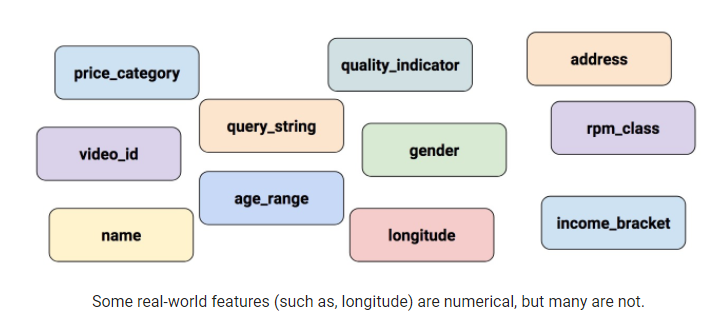

## 输入至深度神经网络

深度神经网络只能处理数值型的数据，因为神经网络中的每一个神经元都在权重和输入数据上执行乘法和加法运算。但是，真实的数据通常包含非数值数据。例如，一个产品类型可能包含以下三种非数字类别：
- 厨房用品
- 电子产品
- 体育用品
机器学习通常将分类数值表示为简单的向量，其中1表示属于该分类，0表示不属于该分类。例如，若产品类型为体育用品，机器学习模型则将其表示为[0, 0, 1]，意味着：
- 0： 不是厨房用品
- 0： 不是电子产品
- 0： 是体育用品
因此尽管原始数据可以是数值型或分类类型，机器学习模型都可以将其表示为数值。

## 特征列

如下图所示，通过Estimator的feature_column参数来指定模型的输入。特征列桥接了输入数据和模型。
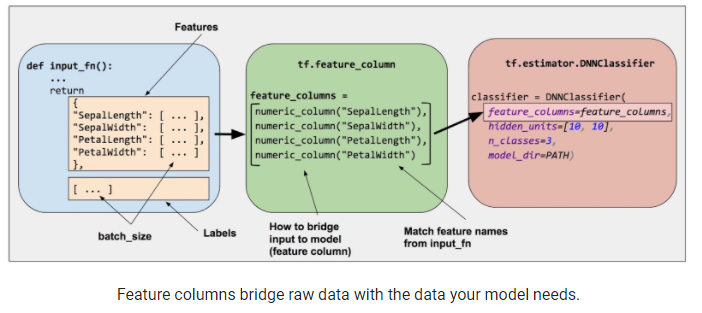

要创建特征列，需要调用**tf.feature_column**模块的函数。本文介绍了模块里面的九种函数。如下图所示，所有的函数都会返回一个Categorical Column或者Dense Column。
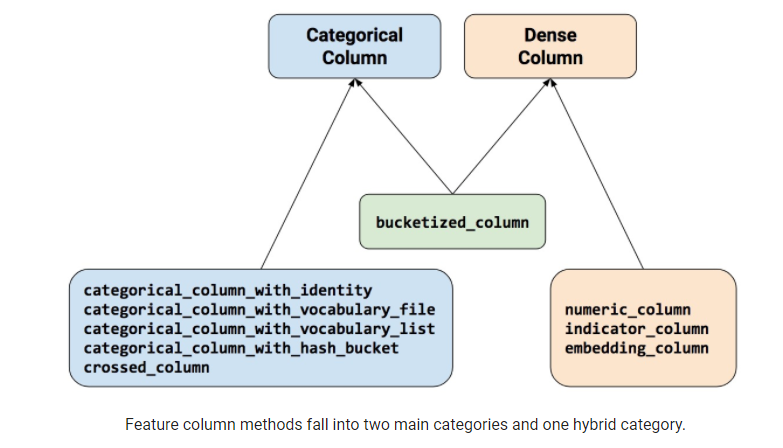

## Numeric column

Iris分类器对所有的输入特征都调用了**tf.feature_column.numeric_column**：
- SepalLength
- SepalWidth
- PetalLength
- PetalWidth

尽管**tf.feature_column**提供了可选参数，但是可以不传任何参数去调用**tf.feature_column**。如下，可以为输入指定默认的数值类型（tf.float32）：

In [ ]:
# 默认设置为tf.float32
numeric_feature_column = tf.feature_column.numeric_column(key="SepalLength")

如要指定非默认的数值类型，可以传递**dtype**参数：

In [ ]:
# 通过参数设置为tf.float32
numeric_feature_column = tf.feature_column.numeric_column(key="SepalLength",
                                                          dtype=tf.float64)

默认情况下，一个数值列会创建一个单独的值（标量）。使用shape参数可以指定另一个shape。例如：

In [ ]:
# 定义包含10个元素的向量，每个单元是一个tf.float32
vector_feature_column = tf.feature_column.numeric_column(key="Bowling",
                                                         shape=10)

# 定义一个10x5的矩阵，每个单元都是一个tf.float32.
matrix_feature_column = tf.feature_column.numeric_column(key="MyMatrix",
                                                         shape=[10,5])

## Bucketized column

通常，不希望将输入的数值直接输入到模型中，而是根据数值范围将其划分为不同的类型。为此，可以创建一个**bucketized column**。例如，一份房屋建造年份的数据，我们可以将年份分成以下四个类别：
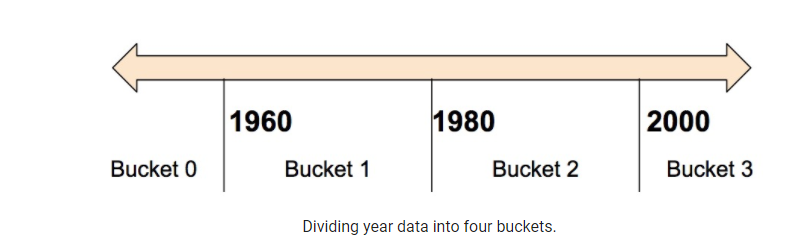

模型会如下所示进行分桶：
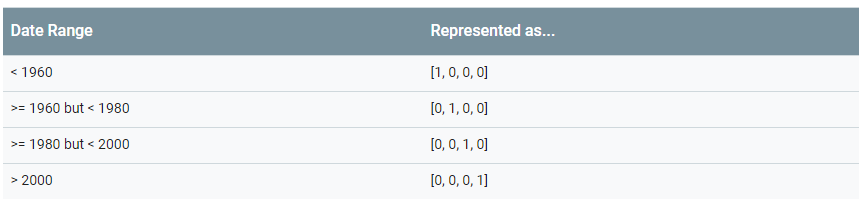

为啥要把一个有效的数值，划分成一个分类值？这里将单个输入的数值分解成了4个元素的向量。因此，这个模型现在可以学习四个单独的权重而不是一个；四个权重的模型比一个权重的模型更丰富。更重要的是，模块化使得模型能更清楚地区分不同年份的类型，因为只有一个元素被设置为1，其他都被设置为0。当我们只使用一个数值作为输入时，模型只能习得线性关系。分桶能为模型学习提供额外的灵活性。 
  
下面代码展示了如何分桶：

In [ ]:
# 首先将输入转换为数值型
numeric_feature_column = tf.feature_column.numeric_column("Year")

# 然后将数值列按照年份1960, 1980, 和 2000进行分桶。
bucketized_feature_column = tf.feature_column.bucketized_column(
    source_column = numeric_feature_column,
    boundaries = [1960, 1980, 2000])

注意，指定一个三元素的边界矢量，会创建一个四元素的被分解的矢量

## Categorical identity column

Categorical identity column 可以被看作是一个特殊的桶型列。在传统的桶型列中，每个桶代表一系列的值（例如，从1960年至1979年）。在Categorical identity column中，每个桶代表一个唯一的数。例如，假设你想要表示范围[0, 4]。意思就是，你想要表示0， 1， 2， 3。这种情况下，Categorical identity column的映射如下所示：
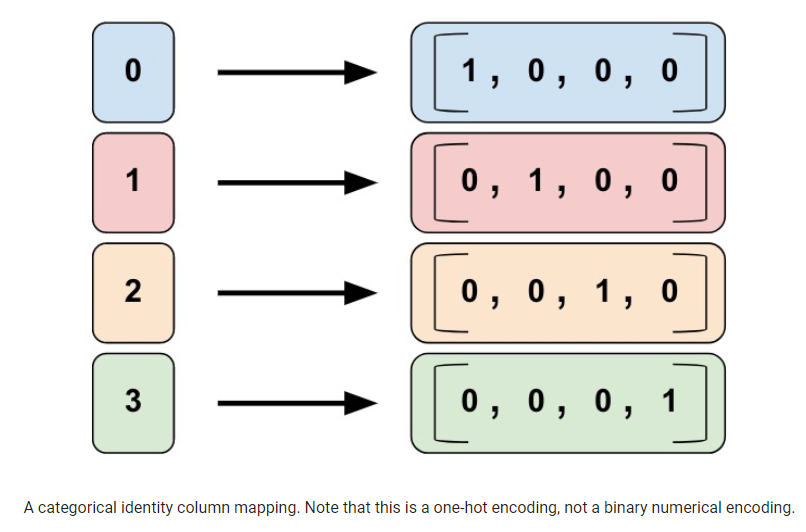

就像bucketized column，在分类标标识中，一个模型可以为每个分类学习单独的权重。例如，与其使用一个字符串来表示product class，不如用唯一的数字来表示:
- 0： 厨房用品
- 1： 电子产品
- 2： 体育用品

调用**tf.feature_column.categorical_column_with_identity**来实现分类标识列。如：

In [ ]:
# 船舰一个叫my_feature_b的分类，其输出为整型特征值,
# my_feature_b的值必须 >= 0 并且 < 分桶数量
identity_feature_column = tf.feature_column.categorical_column_with_identity(
    key='my_feature_b',
    num_buckets=4) # 值为 [0, 4)

# 为了使前面的调用生效, 输入函数 input_fn() 必须返回一个字典类型，其键值
# 包含'my_feature_b'。此外，分配给'my_feature_b'的值必须属于集合[0, 4)
def input_fn():
    ...
    return ({ 'my_feature_a':[7, 9, 5, 2], 'my_feature_b':[3, 1, 2, 2] },
            [Label_values])

## Categorical vocabulary column

我们不能将字符串直接输入到模型中。相反，我们必须首先将字符串映射到数字或分类值。分类词汇表提供了一种很好的方式来表示字符串作为独热编码。例如:
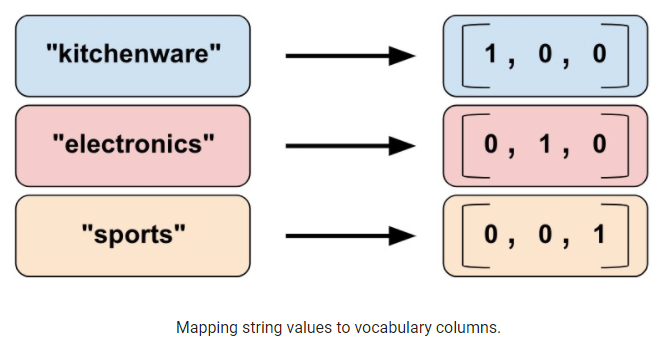

你可以看到，分类词汇表是分类标识列的枚举版本。TensorFlow提供了两个不同的函数来创建分类词汇表：
- tf.feature_column.categorical_column_with_vocabulary_list
- tf.feature_column.categorical_column_with_vocabulary_file

**categorical_column_with_vocabulary_list** 根据词汇表，将每一个字符串映射为一个整型。如：

In [ ]:
# 给定输入字符串，通过和词汇表的映射，创建一个分类特征
vocabulary_feature_column =
    tf.feature_column.categorical_column_with_vocabulary_list(
        key="a feature returned by input_fn()",
        vocabulary_list=["kitchenware", "electronics", "sports"])

前面的函数非常简单，但是它有一个明显的缺点。当词汇表很长是，会做很多的打字操作。对于这些情况，调用**tf.feature_column.categorical_column_with_vocabulary_file**，它可以将词汇表通过文件的方式输入。如：

In [ ]:
# 给定输入字符串，通过和词汇表的映射，创建一个分类特征
vocabulary_feature_column =
    tf.feature_column.categorical_column_with_vocabulary_file(
        key="a feature returned by input_fn()",
        vocabulary_file="product_class.txt",
        vocabulary_size=3)

**product_class.txt** 需每一行包含一个词汇，如：  
kitchenware  
electronics  
sports  

## Hashed Column

上面的例子中product class只有三个类别，当对于大多数情况来讲，类别的数量是非常巨大的，以至于不可能为每个单词或整数进行单独分类，因为那样会耗费太多内存。对于这种情况，我们可以反过来问，“我们需要在输入中包含多少个类别？”。事实上，**tf.feature_column.categorical_column_with_hash_bucket**函数可以指定类别数量。对于这种类型的特征列，模型计算输入的哈希值，然后使用模块化操作符将其放入一个hash_bucket_size类别中，如下面伪代码：

In [ ]:
# 伪代码
feature_id = hash(raw_feature) % hash_buckets_size

创建feature_column的代码可能是这样的

In [ ]:
hashed_feature_column =
    tf.feature_column.categorical_column_with_hash_bucket(
        key = "some_feature",
        hash_buckets_size = 100) # 分类数量

在这一点上，你可能会理所当然地认为：“这太疯狂了！”毕竟，我们正在将不同的输入值强制到一组更小的类别中。这意味着两个可能不相关的输入将被映射到相同的类别，因此对神经网络也意味着相同的东西。下图说明了这一困境，表明厨房用品和体育用品都被分配到类别（hash bucket）12中:
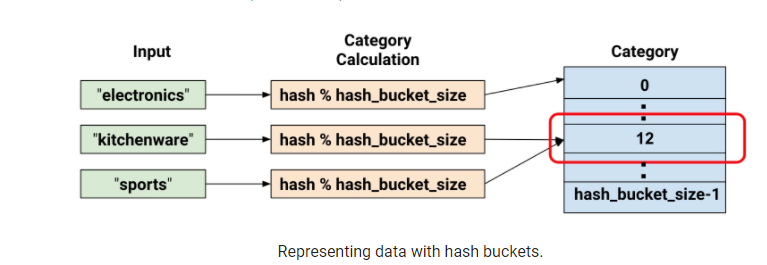

与机器学习中的大多数反直觉现象一样，事实证明，在实践中哈希常常能运行的很好。这是因为哈希分类提供了一些分离的模型。该模型可以使用额外的特征来进一步分离厨房用品和体育用品。

## Crossed column

将多个特征列合并为一个特征列，也就是特征组合，使模型能为每个特征组合学习不同的权重。

更具体地说，假设我们想要我们的模型来计算亚特兰大的房地产价格。这个城市的房价因地理位置而变化很大。将纬度和经度作为单独的特征来表示，对于识别房地产的位置并不是很有用;然而，将经度和纬度转换为单一特征可以精确定位位置。假设我们将亚特兰大作为一个100 x100 矩形的网格表示，通过将经度和纬度进行特征组合，来定位10000个单位中的每一个。这样，特性组合使模型每个独立的个体定价上进行训练，这比把经度和纬度分别作为特征来训练，效果更佳显著。
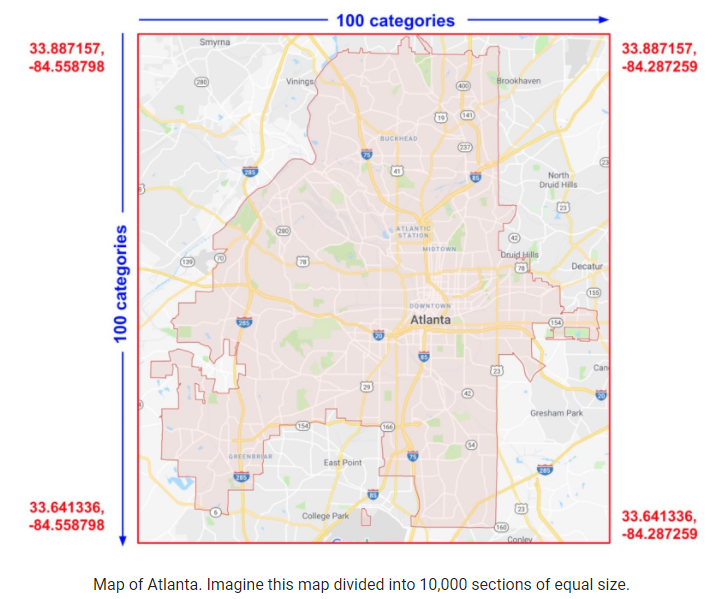

为了解决这个问题，需要使用前面的bucketized_column和tf.feature_column.crossed_column函数。

In [ ]:
def make_dataset(latitude, longitude, labels):
    assert latitude.shape == longitude.shape == labels.shape

    features = {'latitude': latitude.flatten(),
                'longitude': longitude.flatten()}
    labels=labels.flatten()

    return tf.data.Dataset.from_tensor_slices((features, labels))

# 使用边界来对经纬度分桶
latitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    list(atlanta.latitude.edges))

longitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    list(atlanta.longitude.edges))

# 5000 hash bins来对经纬度分桶进行特征组合
crossed_lat_lon_fc = tf.feature_column.crossed_column(
    [latitude_bucket_fc, longitude_bucket_fc], 5000)

fc = [
    latitude_bucket_fc,
    longitude_bucket_fc,
    crossed_lat_lon_fc]

# 构造并训练模型
est = tf.estimator.LinearRegressor(fc, ...)

你可以用以下方式创建特征组合：
- 特征名称，从输入函数返回的字典
- 任何categorical column，除了categorical_column_with_hash_bucket

当特征列latitude_bucket_fc和longitude_bucket_fc组合后，Tensorflow会为每个样本创建一个(latitude_fc, longitude_fc)特征。这将产生一个完整的可能性网格，如下所示：

In [ ]:
(0,0),  (0,1)...  (0,99)
 (1,0),  (1,1)...  (1,99)
   ...     ...       ...
(99,0), (99,1)...(99, 99)

除了一个完整的网格只对有限词汇表的输入是可处理的。与构建这个潜在的巨大的输入表不同，crossed_column只通过hash_bucket_size参数构建所请求的编号。特性列通过在输入元组上执行一个哈希函数来为一个索引分配一个样本，然后是一个带有hash_bucket_size的模块化操作。  
  
正如前面所讨论的，执行哈希和模块化函数限制了类别的数量，但是可能导致类别冲突;也就是说，多个（经度、纬度）特性的组合最终会在同一个哈希表中。但在实践中，执行特征组合仍然会给模型的学习能力带来显著的价值。  
  
有点违背直觉的是，在创建特征组合时，您通常仍然应该在模型中包含原始的（为组合的）特性（如前面的代码片段）。独立的纬度和经度特征帮助模型区分在特征组合中发生哈希冲突的样本。

## Indicator and embedding columns

indicator columns和embedding columns从不直接操作特征，而是用categorical column作为输入。
  
indicator columns将每个类别视为一个独热编码中的一个元素，其中类别匹配的值为1，其余的为0。
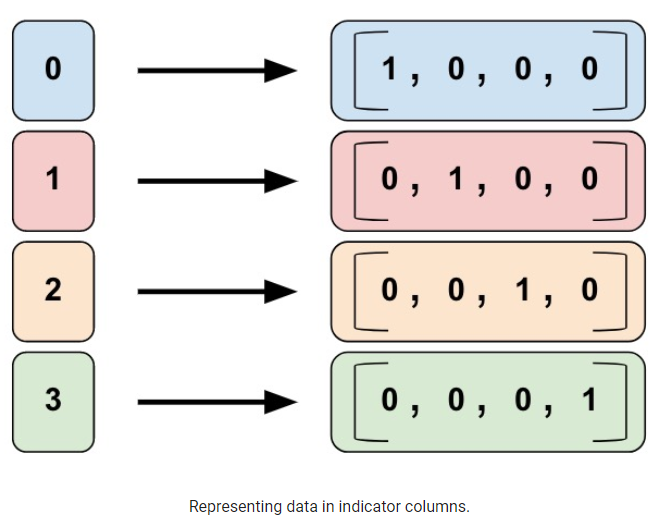

下面介绍如何通过调用 tf.feature_column.indicator_column来创建indicator columns：

In [ ]:
categorical_column = ... # 创建任何类型的categorical column

# 将categorical column 作为 indicator column
indicator_column = tf.feature_column.indicator_column(categorical_column)

现在，假设不只有三个分类，有一百万或者十亿个分类。由于许多原因，随着类别数量的增长，使用inicator column来训练神经网络变得不可行。  

我们可以使用embedding column来克服这个限制。不再将数据表示为多维度的独热编码，而是将数据表示为一个低纬度的普通向量，其中每个单元可以包含仍和数字，而不仅仅是0和1。通过允许每个单元可以包含更多的数字，一个embedding column所包含的单元格会比indicator column少得多。 
  
下面看一个indicator column 和embedding column的例子。假设我们输入的样例是从81个单词里面产生的不同单词。进一步假设，数据集中提供了以下4个样例：
- "dog"
- "spoon"
- "scissors"
- "guitar"  
  
在这种情况下，下图说明了indicator column或embedding column的执行步骤。
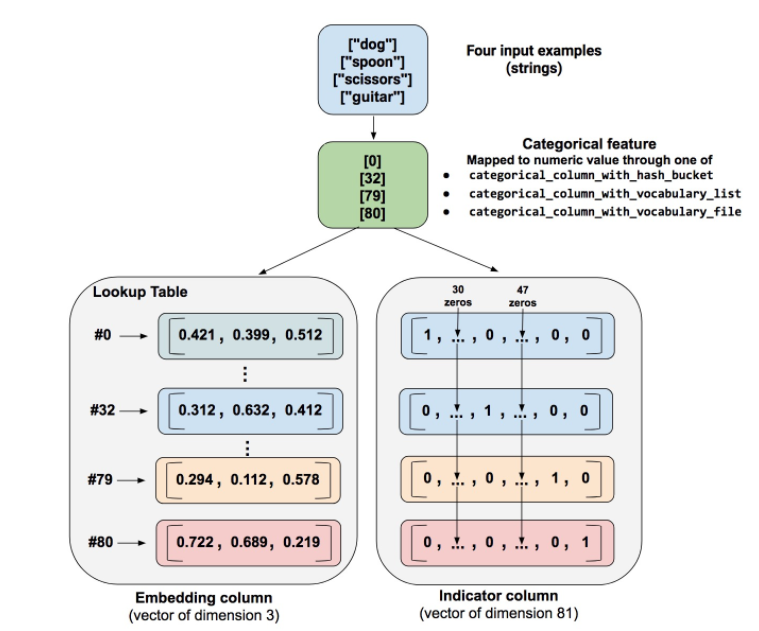

对于分类数据所表示的向量，Embedding column比Indicator column维度更低。  
  
当一个样本被处理时，其中一个 categorical_column_with...函数，会将示例的字符串值转换为数值分类值。例如，一个函数将"spoon"转换为[32]（32是我们假设的，实际的数值依赖于映射函数）。然后我们用以下两种方式来表示这些数值分类值：
- 作为indicator column。一个函数将分类数值分解为81的元素的向量（因为我们的词袋有81个单词），将1放在索引(0, 32, 79, 80)的位置，其余位置均为0。
- 作为embedding column。一个函数将分类数值(0, 32, 79, 80)作为一个查找表的索引。这个查找表的每一个位置都是一个3个元素的向量。
  
Embedding column向量中的值是如何分配的？实际上，值的分配发生于训练期间。也就是说，模型学习了将数值分类值映射为适量值的最优方法，以解决你的问题。Embedding column增加了模型的能力，因为embedding向量从训练数据中学习了不同类别间的新关系。  
  
为什么我们例子中embedding向量的长度是3？下面的公式提供了embedding维度的一般规则：

In [ ]:
embedding_dimensions =  number_of_categories**0.25

也就是说，embedding向量的维度应该是分类数量的4次方根。因为本例中分类数量为81，所以推荐的维度为3：

In [ ]:
3 =  81**0.25

请注意，这只是一个一般性的指导方针;您可以按您的意愿设置嵌入维度的数量。

调用tf.feature_column.embedding_column函数来创建embedding_column，如下面代码所示：

In [ ]:
categorical_column = ... # Create any categorical column

# Represent the categorical column as an embedding column.
# This means creating a one-hot vector with one element for each category.
embedding_column = tf.feature_column.embedding_column(
    categorical_column=categorical_column,
    dimension=dimension_of_embedding_vector)

Embedding是机器学习中一个重要的课题。前面的介绍只是为了让你开始对特征列来使用embedding column。

## 将特征列传递给Estimator

如下面indicate表所示，并非所有的Esitmator的feature_columns参数都接受所有类型
- LinearClassifier和LinearRegressor: 接受所有类型的特征列
- DNNClassifier和DNNRegressor: 只接受密集的列。其他类型必须包装在一个indicator_column或embedding_column中
- DNNLinearCombinedClassifier和DNNLinearCombinedRegressor:
 - linear_feature_columns参数接受任何特征列类型
 -  dnn_feature_columns参数只接受密集列